In [1]:
import numpy as np
import pandas as pd
import dataframe_image as dfi

import matplotlib.pyplot as plt
import datetime
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import ast

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터프레임을 그림 파일로 저장
save_option = 1 # 1 : dfi / 2 : df2img / 3 : do nothing
demand_option = 1 # 1: 전체수요 / 2 : 2030수요
K_option = 7 # 군집수 (5, 6, 7)
if demand_option == 1:
    suffix = "_entire_pop_"
if demand_option == 2:
    suffix = "_2030_pop_"

import df2img
def save(df:pd.DataFrame, path:str, extension:str):
    path = path + suffix + "K="+str(K_option) + "." + extension
    if extension == 'png':
        if save_option == 1:
            dfi.export(df, path)
        if save_option == 2:
            df2img.save_dataframe(fig=df2img.plot_dataframe(df), filename=path)
        if save_option == 3:
            pass
    if extension == 'csv':
        df.to_csv(path, encoding="utf-8-sig")

In [3]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:\Windows\Fonts\malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 데이터 전처리

In [4]:
# 해커톤 데이터 불러오기 및 이름 수정
hackathon_data_original = pd.read_csv("../../data/20211022_수요예측_hackathon_data.csv", encoding='cp949')
hackathon_data_original['region2'].replace({ 
    '수원시\u3000팔달구':'수원시 팔달구', '수원시\u3000영통구':'수원시 영통구', '용인시\u3000기흥구':'용인시 기흥구',
    '고양시\u3000일산동구':'고양시 일산동구', '안양시\u3000동안구':'안양시 동안구', '고양시\u3000일산서구':'고양시 일산서구',
    '성남시\u3000수정구':'성남시 수정구', '수원시\u3000장안구':'수원시 장안구', '성남시\u3000중원구':'성남시 중원구',
    '안산시\u3000단원구':'안산시 단원구', '용인시\u3000수지구':'용인시 수지구', '고양시\u3000덕양구':'고양시 덕양구',
    '용인시\u3000처인구':'용인시 처인구', '안양시\u3000만안구':'안양시 만안구', '성남시\u3000분당구':'성남시 분당구',
    '수원시\u3000권선구':'수원시 권선구', '안산시\u3000상록구':'안산시 상록구',}, inplace=True)
hackathon_data_original['reservation_return_at'] = pd.to_datetime(hackathon_data_original['reservation_return_at'])
hackathon_data_original['reservation_start_at'] = pd.to_datetime(hackathon_data_original['reservation_start_at'])
hackathon_data_original.head()

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model
0,울산광역시,남구,2019-09-29 21:25:40+00:00,2019-09-29 19:20:00+00:00,1,male,경형
1,울산광역시,남구,2019-07-13 13:11:21+00:00,2019-07-13 11:00:00+00:00,1,male,준중형
2,울산광역시,남구,2019-09-16 23:43:08+00:00,2019-09-16 19:10:00+00:00,1,male,준중형
3,울산광역시,남구,2019-08-09 06:17:41+00:00,2019-08-09 00:20:00+00:00,1,male,준중형
4,울산광역시,남구,2019-07-24 12:36:29+00:00,2019-07-24 09:00:00+00:00,2,male,경형


In [5]:
# 경기도 데이터
gyeong_gi = hackathon_data_original[hackathon_data_original['region1']=='경기도']

In [6]:
gyeong_gi['used_time'] = gyeong_gi['reservation_return_at'] - gyeong_gi['reservation_start_at']
gyeong_gi['reservation_return_date'] = gyeong_gi['reservation_return_at'].dt.to_period(freq = 'D')
gyeong_gi['reservation_start_date'] = gyeong_gi['reservation_start_at']. dt.to_period(freq = 'D')
gyeong_gi['week'] = gyeong_gi['reservation_start_date'].dt.dayofweek
gyeong_gi

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model,used_time,reservation_return_date,reservation_start_date,week
44105,경기도,광명시,2019-10-08 12:27:53+00:00,2019-10-07 19:30:00+00:00,1,male,소형SUV,0 days 16:57:53,2019-10-08,2019-10-07,0
44106,경기도,광명시,2019-05-14 12:50:00+00:00,2019-05-13 13:00:00+00:00,4,male,준중형SUV,0 days 23:50:00,2019-05-14,2019-05-13,0
44107,경기도,광명시,2019-01-11 17:14:14+00:00,2019-01-11 13:30:00+00:00,1,male,소형SUV,0 days 03:44:14,2019-01-11,2019-01-11,4
44108,경기도,광명시,2019-04-07 19:54:19+00:00,2019-04-07 10:30:00+00:00,3,female,소형SUV,0 days 09:24:19,2019-04-07,2019-04-07,6
44109,경기도,광명시,2019-09-20 22:47:39+00:00,2019-09-20 16:20:00+00:00,2,male,준중형,0 days 06:27:39,2019-09-20,2019-09-20,4
...,...,...,...,...,...,...,...,...,...,...,...
457062,경기도,고양시 일산서구,2019-09-14 12:25:29+00:00,2019-09-14 12:00:00+00:00,1,male,경형,0 days 00:25:29,2019-09-14,2019-09-14,5
457063,경기도,고양시 일산서구,2019-07-25 15:30:00+00:00,2019-07-24 18:30:00+00:00,4,female,준중형,0 days 21:00:00,2019-07-25,2019-07-24,2
457064,경기도,고양시 일산서구,2019-07-14 22:38:09+00:00,2019-07-14 21:30:00+00:00,1,male,경형,0 days 01:08:09,2019-07-14,2019-07-14,6
457065,경기도,고양시 일산서구,2019-06-20 18:25:37+00:00,2019-06-20 18:10:00+00:00,1,unknown,소형SUV,0 days 00:15:37,2019-06-20,2019-06-20,3


In [7]:
gyeong_gi['gender'] = gyeong_gi['gender'].apply(lambda x: 0 if x == 'male' else 1)
gyeong_gi['is_weekend'] = gyeong_gi['week'].apply(lambda x: 0 if x < 5 else 1)
gyeong_gi

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model,used_time,reservation_return_date,reservation_start_date,week,is_weekend
44105,경기도,광명시,2019-10-08 12:27:53+00:00,2019-10-07 19:30:00+00:00,1,0,소형SUV,0 days 16:57:53,2019-10-08,2019-10-07,0,0
44106,경기도,광명시,2019-05-14 12:50:00+00:00,2019-05-13 13:00:00+00:00,4,0,준중형SUV,0 days 23:50:00,2019-05-14,2019-05-13,0,0
44107,경기도,광명시,2019-01-11 17:14:14+00:00,2019-01-11 13:30:00+00:00,1,0,소형SUV,0 days 03:44:14,2019-01-11,2019-01-11,4,0
44108,경기도,광명시,2019-04-07 19:54:19+00:00,2019-04-07 10:30:00+00:00,3,1,소형SUV,0 days 09:24:19,2019-04-07,2019-04-07,6,1
44109,경기도,광명시,2019-09-20 22:47:39+00:00,2019-09-20 16:20:00+00:00,2,0,준중형,0 days 06:27:39,2019-09-20,2019-09-20,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
457062,경기도,고양시 일산서구,2019-09-14 12:25:29+00:00,2019-09-14 12:00:00+00:00,1,0,경형,0 days 00:25:29,2019-09-14,2019-09-14,5,1
457063,경기도,고양시 일산서구,2019-07-25 15:30:00+00:00,2019-07-24 18:30:00+00:00,4,1,준중형,0 days 21:00:00,2019-07-25,2019-07-24,2,0
457064,경기도,고양시 일산서구,2019-07-14 22:38:09+00:00,2019-07-14 21:30:00+00:00,1,0,경형,0 days 01:08:09,2019-07-14,2019-07-14,6,1
457065,경기도,고양시 일산서구,2019-06-20 18:25:37+00:00,2019-06-20 18:10:00+00:00,1,1,소형SUV,0 days 00:15:37,2019-06-20,2019-06-20,3,0


In [8]:
cities = gyeong_gi['region2'].unique()
cities

array(['광명시', '구리시', '김포시', '양평군', '하남시', '화성시', '남양주시', '의정부시',
       '고양시 덕양구', '성남시 분당구', '성남시 수정구', '성남시 중원구', '안양시 동안구', '안양시 만안구',
       '고양시 일산동구', '고양시 일산서구'], dtype=object)

In [54]:
K = K_option

In [60]:
cluster_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
cluster_names = cluster_names[:K]
cluster_names

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [61]:
clustering_result = pd.read_csv("../code_b_clustering/results/1b213_0126_clustering_result" + suffix + "K=" + str(K_option) + ".csv")
clustering_result

,군집,소속도시
0,A,"['용인시 기흥구', '성남시 분당구', '시흥시', '김포시', '고양시 덕양구'..."
1,B,"['양평군', '여주시', '과천시', '포천시', '동두천시', '가평군', '연..."
2,C,['평택시']
3,D,"['수원시 장안구', '용인시 처인구', '안산시 단원구', '안양시 동안구', '..."
4,E,"['부천시', '화성시', '남양주시']"
5,F,"['수원시 권선구', '수원시 영통구', '용인시 수지구', '안산시 상록구', '..."
6,G,"['수원시 팔달구', '성남시 수정구', '성남시 중원구', '안양시 만안구', '..."


In [62]:
cluster_range = list(range(K))
cluster_range

[0, 1, 2, 3, 4, 5, 6]

In [13]:
clusters = []
for k in range(K):
    clusters.append(sorted(ast.literal_eval(clustering_result['소속도시'][k])))

In [14]:
print("각 군집별 도시들")
for k in range(K):
    print("cluster",cluster_names[k],":", clusters[k])

각 군집별 도시들
cluster A : ['고양시 덕양구', '김포시', '성남시 분당구', '시흥시', '용인시 기흥구', '의정부시', '파주시']
cluster B : ['가평군', '과천시', '동두천시', '양평군', '여주시', '연천군', '포천시']
cluster C : ['평택시']
cluster D : ['고양시 일산동구', '고양시 일산서구', '광명시', '군포시', '수원시 장안구', '안산시 단원구', '안양시 동안구', '용인시 처인구', '하남시']
cluster E : ['남양주시', '부천시', '화성시']
cluster F : ['광주시', '수원시 권선구', '수원시 영통구', '안산시 상록구', '용인시 수지구']
cluster G : ['구리시', '성남시 수정구', '성남시 중원구', '수원시 팔달구', '안성시', '안양시 만안구', '양주시', '오산시', '의왕시', '이천시']


In [15]:
print("각 군집별 (수요 데이터가 있는) 도시들")
for k in range(K):
    print("Cluster", cluster_names[k], ":", sorted(set.intersection(set(clusters[k]), set(cities))))

각 군집별 (수요 데이터가 있는) 도시들
Cluster A : ['고양시 덕양구', '김포시', '성남시 분당구', '의정부시']
Cluster B : ['양평군']
Cluster C : []
Cluster D : ['고양시 일산동구', '고양시 일산서구', '광명시', '안양시 동안구', '하남시']
Cluster E : ['남양주시', '화성시']
Cluster F : []
Cluster G : ['구리시', '성남시 수정구', '성남시 중원구', '안양시 만안구']


In [16]:
data_original_ = [gyeong_gi[gyeong_gi['region2'].isin(clusters[k])] for k in range(K)]
data_original_[0]

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model,used_time,reservation_return_date,reservation_start_date,week,is_weekend
79761,경기도,김포시,2019-09-01 20:10:10+00:00,2019-09-01 13:30:00+00:00,1,1,경형,0 days 06:40:10,2019-09-01,2019-09-01,6,1
79762,경기도,김포시,2019-11-30 21:25:45+00:00,2019-11-30 14:40:00+00:00,1,0,준중형,0 days 06:45:45,2019-11-30,2019-11-30,5,1
79763,경기도,김포시,2019-01-13 23:00:47+00:00,2019-01-13 21:30:00+00:00,1,0,준중형SUV,0 days 01:30:47,2019-01-13,2019-01-13,6,1
79764,경기도,김포시,2019-04-11 20:44:57+00:00,2019-04-11 07:50:00+00:00,2,0,경형,0 days 12:54:57,2019-04-11,2019-04-11,3,0
79765,경기도,김포시,2019-05-13 14:58:43+00:00,2019-05-13 12:40:00+00:00,3,0,소형SUV,0 days 02:18:43,2019-05-13,2019-05-13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
306649,경기도,성남시 분당구,2019-11-19 14:27:53+00:00,2019-11-19 08:30:00+00:00,3,0,준중형,0 days 05:57:53,2019-11-19,2019-11-19,1,0
306650,경기도,성남시 분당구,2019-06-28 09:23:36+00:00,2019-06-27 14:30:00+00:00,2,0,준대형,0 days 18:53:36,2019-06-28,2019-06-27,3,0
306651,경기도,성남시 분당구,2019-03-25 01:57:52+00:00,2019-03-24 23:00:00+00:00,1,0,준중형,0 days 02:57:52,2019-03-25,2019-03-24,6,1
306652,경기도,성남시 분당구,2019-07-23 07:18:45+00:00,2019-07-22 18:00:00+00:00,2,0,준중형SUV,0 days 13:18:45,2019-07-23,2019-07-22,0,0


In [17]:
time_interval = pd.date_range('2019-01-01', '2019-11-30')
time_interval

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-11-21', '2019-11-22', '2019-11-23', '2019-11-24',
               '2019-11-25', '2019-11-26', '2019-11-27', '2019-11-28',
               '2019-11-29', '2019-11-30'],
              dtype='datetime64[ns]', length=334, freq='D')

In [18]:
# missing data 이슈를 처리하기 위해 참고할 만한 코드
# df = pd.DataFrame({'A':[1,3,5],'Sales':[20,50,80]})
# df.set_index('A', inplace=True)
# df.reindex(list(range(df.index.min(),df.index.max()+1)), fill_value=0)
# #df

In [19]:
def make_timeseries(data_original):
    data = pd.DataFrame(data_original['reservation_start_date'].value_counts())
    data.reset_index(inplace = True)
    data.columns = ['Date', 'Demand']
    data.sort_values(by = ['Date'], inplace = True)
    data['Date'] = data['Date'].astype(str)
    data.reset_index(drop=True, inplace = True)
    data = data[data['Date'] > '2018-12-31'] # 이슈 2 해결
    data['Date'] = pd.to_datetime(data['Date'])
    return data

In [20]:
# AA = np.array([cluster_range, cluster_names]).T
# AA

array([['0', 'A'],
       ['1', 'B'],
       ['2', 'C'],
       ['3', 'D'],
       ['4', 'E'],
       ['5', 'F'],
       ['6', 'G']], dtype='<U11')

In [21]:
# BB = AA[~np.array([data_original_[k].empty for k in range(K)])].T
# BB

array([['0', '1', '3', '4', '6'],
       ['A', 'B', 'D', 'E', 'G']], dtype='<U11')

In [22]:
# cluster_range = BB[0].astype(int)
# cluster_range

array([0, 1, 3, 4, 6])

In [23]:
# cluster_names = BB[1]

In [63]:
data_ = []
for k in range(K):
    if not data_original_[k].empty:
        data_.append(make_timeseries(data_original_[k]))
    else:
        del cluster_range[k]
        data_.append(pd.DataFrame())
len(data_)

7

In [64]:
pd.DataFrame([cluster_range, cluster_names])

,0,1,2,3,4
0,0,1,3,4,5
1,A,B,D,E,F


In [26]:
# 각 군별 '일 수', 전체 '일 수'
# dataD의 경우 날짜 하나가 빠져있다.
data_lengths = [data['Date'].nunique() for data in data_ if not data.empty]
data_lengths

[334, 333, 334, 334, 334]

In [27]:
j = data_lengths.index(333)

In [28]:
print(len(pd.date_range(start="2019-01-01", end="2019-11-30")))

334


In [29]:
# 빠진 날짜는 1월 30일
pd.date_range(start="2019-01-01", end="2019-11-30").difference(pd.to_datetime(data_[j]['Date']))

DatetimeIndex(['2019-01-30'], dtype='datetime64[ns]', freq=None)

In [30]:
data_[j][27:32]

,Date,Demand
28,2019-01-28,8
29,2019-01-29,6
30,2019-01-31,4
31,2019-02-01,8
32,2019-02-02,9


In [31]:
# 이슈 1 해결
# 채워넣었다.
data_[j] = data_[j].append({'Date':datetime.datetime.strptime('2019-01-30', '%Y-%m-%d'), 'Demand':0}, ignore_index=True)
data_[j].sort_values(by='Date', inplace=True)
data_[j][27:32]

,Date,Demand
27,2019-01-28,8
28,2019-01-29,6
333,2019-01-30,0
29,2019-01-31,4
30,2019-02-01,8


In [32]:
print([data['Date'].nunique() for data in data_ if not data.empty])

[334, 334, 334, 334, 334]


# plot

In [33]:
L = len(data_[0]['Date'])
n_split = int(L*0.8)
print(L)
print(n_split)

334
267


In [34]:
# index를 time으로, time을 index로 바꾸는 dictionary
index_to_time = dict(zip(range(L), data_[0]['Date']))
time_to_index = {time:index for (index,time) in index_to_time.items()}
# 처음 날짜, # 끝 날짜
print(index_to_time[0], index_to_time[L-1])

2019-01-01 00:00:00 2019-11-30 00:00:00


In [35]:
# train-test split 날짜
print(index_to_time[n_split])

2019-09-25 00:00:00


In [38]:
cluster_range

array([0, 1, 3, 4, 6])

IndexError: list index out of range

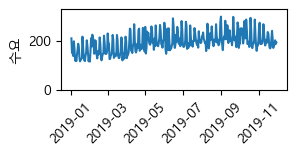

In [71]:
i=6
plt.subplot(nrows, ncols, i+1)
plt.plot(data_[i]['Date'],data_[i]['Demand'])
plt.ylabel('수요')
plt.ylim(0, max(data_[i]['Demand'])*1.1)
plt.xticks(rotation=45)
plt.title('군집 '+str(cluster_names[i]))
plt.axvline(x = index_to_time[n_split], color = 'r', linestyle='dashed')

IndexError: index 6 is out of bounds for axis 0 with size 5

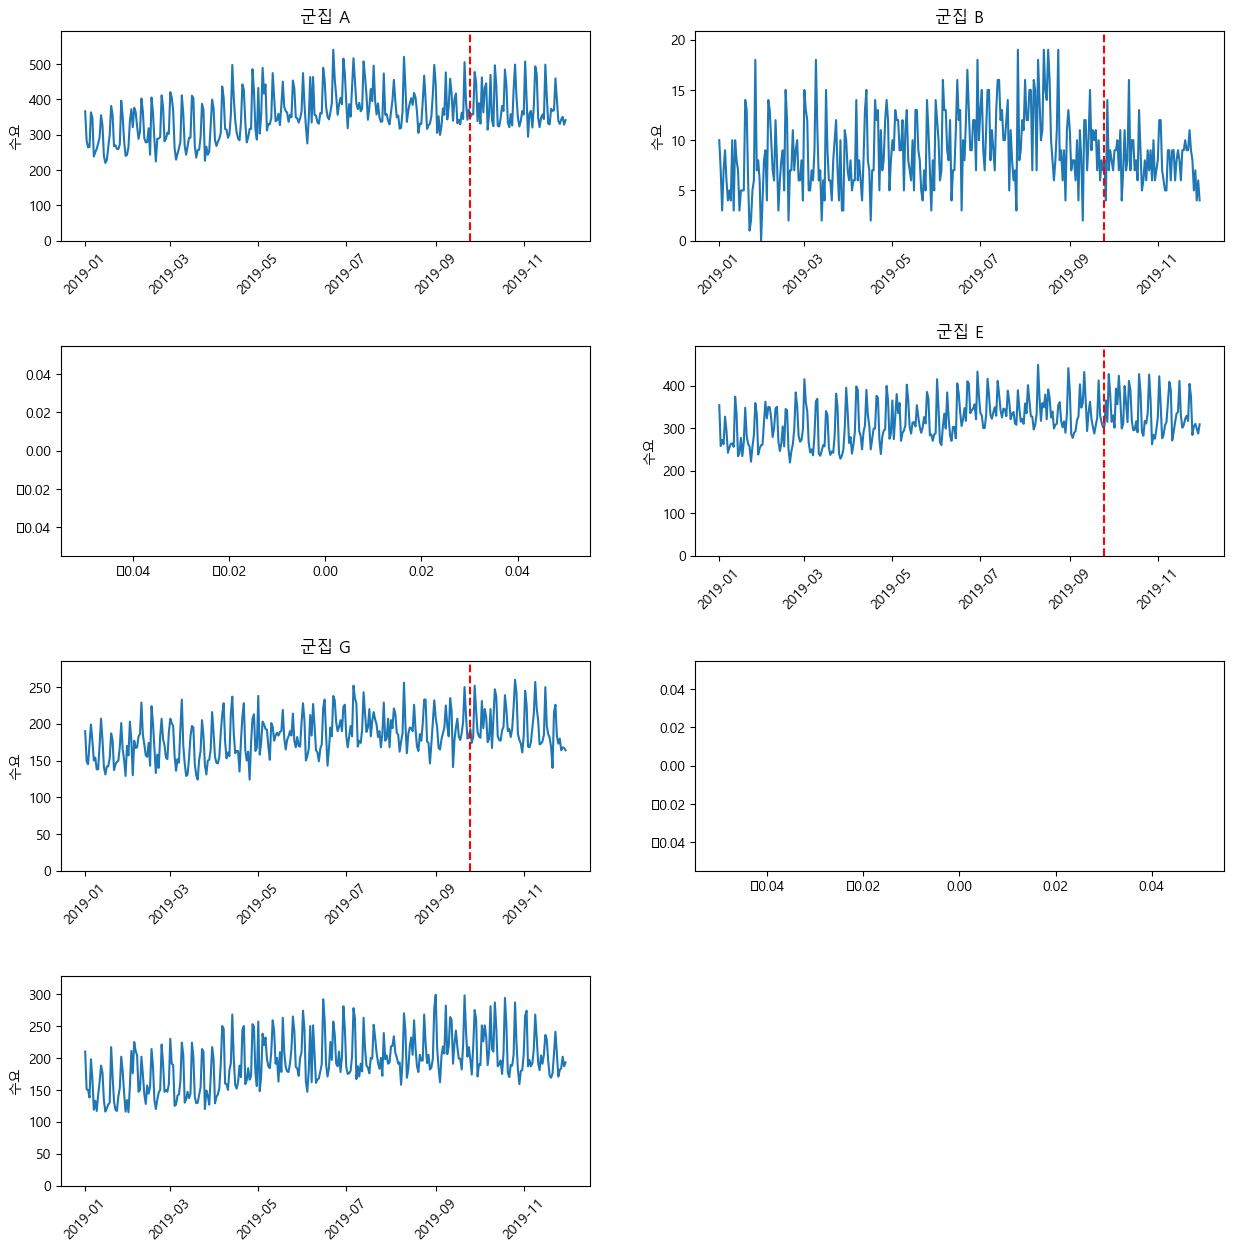

In [44]:
if K <= 6:
    nrows, ncols = 3, 2
else:
    nrows, ncols = 4, 2
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=.5)
for i in cluster_range:
    plt.subplot(nrows, ncols ,i+1)
    plt.plot(data_[i]['Date'],data_[i]['Demand'])
    plt.ylabel('수요')
    plt.ylim(0, max(data_[i]['Demand'])*1.1)
    plt.xticks(rotation=45)
    plt.title('군집 '+str(cluster_names[i]))
    plt.axvline(x = index_to_time[n_split], color = 'r', linestyle='dashed')
plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 5

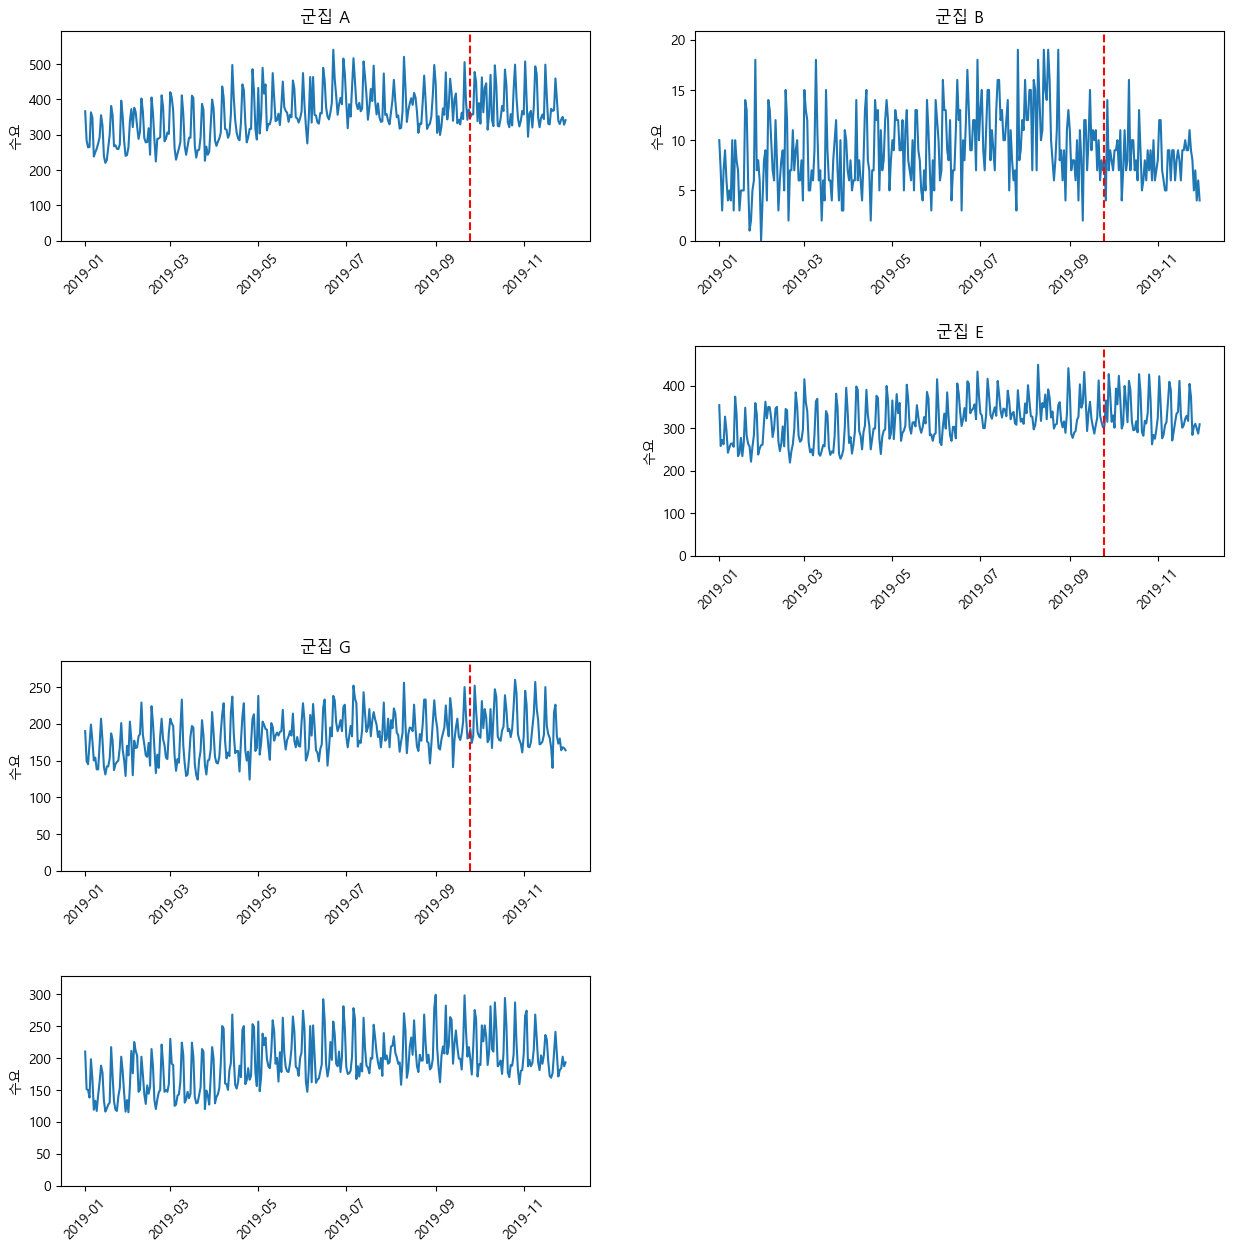

In [36]:
if K <= 6:
    nrows, ncols = 3, 2
else:
    nrows, ncols = 4, 2
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=.5)
for i in cluster_range:
    plt.subplot(nrows, ncols ,i+1)
    plt.plot(data_[i]['Date'],data_[i]['Demand'])
    plt.ylabel('수요')
    plt.ylim(0, max(data_[i]['Demand'])*1.1)
    plt.xticks(rotation=45)
    plt.title('군집 '+str(cluster_names[i]))
    plt.axvline(x = index_to_time[n_split], color = 'r', linestyle='dashed')
plt.show()

# linear model

In [ ]:
x = np.arange(L)
x = np.expand_dims(x, axis=1)
slopes = []
intercepts = []
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=.5)
for i in cluster_range:
    reg = linear_model.LinearRegression()
    y = data_[i]['Demand'].to_numpy()
    reg.fit(x, y)
    slopes.append(reg.coef_[0])
    intercepts.append(reg.intercept_)
    y_hat = reg.coef_*x + reg.intercept_
    plt.subplot(3,2,i+1)
    plt.plot(x[:n_split], y[:n_split])
    plt.plot(x[:n_split], y_hat[:n_split], c='magenta', linestyle='dashed', linewidth=.8)
    plt.plot(x[n_split:], y_hat[n_split:], c='magenta')
    plt.axvline(x = n_split, color = 'r', linestyle='dashed')
    plt.title('군집 '+str(cluster_names[i])+', (기울기 : '+str(round(reg.coef_[0],3))+')')

In [ ]:
print(slopes, intercepts, sep='\n')

In [ ]:
x = np.arange(L)
x_train = x[:n_split]
x_test = x[n_split:]


In [ ]:
MSEs = []
y_test_preds = []
y_train_trues = []
for i in cluster_range:
    x_test = np.arange(L)[n_split:]
    y_test_pred = slopes[i]*x_test + intercepts[i]
    y_train_true = data_[i]['Demand'].to_numpy()[:n_split]
    y_test_true = data_[i]['Demand'].to_numpy()[n_split:]
    MSEs.append(mean_squared_error(y_test_pred, y_test_true))
    y_test_preds.append(y_test_pred)
    y_train_true = list(map(float, y_train_true))
    y_train_trues.append(y_train_true)
for i in cluster_range:
    print("MSE of cluster" , cluster_names[i] , ":", MSEs[i])

In [ ]:
from statistics import mean
mean_y_train_trues = [mean(y_train_true) for y_train_true in y_train_trues]
mean_y_test_preds = [mean(y_test_pred) for y_test_pred in y_test_preds]
increasing_ratios = np.array(mean_y_test_preds)/np.array(mean_y_train_trues)
result = pd.DataFrame({#'MSE':MSEs,
                        '학습 데이터의 실제값 평균':mean_y_train_trues,
                        '테스트 데이터의 예측값 평균':mean_y_test_preds,
                        '증가비율':increasing_ratios}, index=cluster_names)
result.index.name='군집'
result.round(4)

In [ ]:
print('total MSE:', round(mean(MSEs), 4))